In [1]:
from nimlab import datasets as nimds
import numpy as np
from nilearn import image, plotting, maskers
import nibabel as nib
import os
import pandas as pd
import glob
import platform
import warnings
warnings.filterwarnings('ignore')

In [9]:
## Paths Input Here
analysis = "rios_worst_versus_top_responders_specificity_map_final"
#Note, given this is comparign the difference between GOOD AND BAD outcomes, 
#you will only be able to know this is the SPECIFICITY FOR A CLINICAL EFFECT map. 
#the regions that drive an improvement or impairment are likely in the nonoverlap maps.
if platform.uname().system == 'Darwin': #------------------------------Mac OS X---------------------------------------------------------------
    connectivity_path = r'/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/rios_2022_networks/connectivity'    
    out_dir = rf'/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/rios_2022_networks/{analysis}'
    clin_path = r'/Users/cu135/Dropbox (Partners HealthCare)/memory/patient_data/AD_Clinical_Data_CDR_ADAS_COG_13.xlsx'
    
    connectivity_path2 = r'/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/ferguson_2019_networks/control_lesions'
    #out_dir = r'path to out dir here'
    print('I have set pathnames in the Mac style')
else: #----------------------------------------------------------------Windows----------------------------------------------------------------
    conn_path = r'C:\Users\calvin.howard\Dropbox (Partners HealthCare)\memory\analyses\roi-roi_correl\matrix_corrMx_AvgR.csv'
    clin_path = r'C:\Users\calvin.howard\Dropbox (Partners HealthCare)\memory\patient_data\AD_Clinical_Data_CDR_ADAS_COG_13.xlsx'
    # clin_path = 'path to clinical values'
    out_dir = r'C:\Users\calvin.howard\Dropbox (Partners HealthCare)\memory\analyses\roi-roi_correl\stats'
    #out_dir = r'path to out dir here'
    x_roi_names = r'C:\Users\calvin.howard\Dropbox (Partners HealthCare)\memory\analyses\roi-roi_correl\matrix_corrMx_names.csv'
    #roi_names = '<path to roi name location>'
    print('I have set pathnames in the Windows style')

I have set pathnames in the Mac style


In [11]:
perform_weighting = False
split_outcomes = True
# responders = 'top'
#only do this if your clinical outcomes are continuous. Causal binary outcomes are already represented in preceding information.
#----------------------------------------------------------------User Input Above----------------------------------------------------------------
#we will generate a weight value derived from each patient's outcome and bias the functional connectivities
clinical_df = pd.read_csv
#We will
sheet_name = 'AD_Clinical_Scores'
alphab_cols = 'D, J'
clin_df = pd.read_excel(clin_path, sheet_name=sheet_name, usecols=alphab_cols, nrows=50)
print('Num NaNs: ', clin_df.isna().sum().sum())
clin_df.sort_values(by='Patient # CDR, ADAS', ascending=True, inplace=True)
if perform_weighting:
    weight_df = clin_df.copy()
if split_outcomes:
    positive_outcome = clin_df['% Change from baseline (ADAS-Cog11)'] >= 0
    negative_outcome =  clin_df['% Change from baseline (ADAS-Cog11)'] < 0
    print('positive outcome: ', np.count_nonzero(positive_outcome))
    print('negative outcome: ', np.count_nonzero(negative_outcome))
display(clin_df)

Num NaNs:  0
positive outcome:  11
negative outcome:  39


,"Patient # CDR, ADAS",% Change from baseline (ADAS-Cog11)
0,101,-21.428571
1,102,-36.363636
2,103,-78.947368
3,104,-129.411765
4,105,-10.526316
5,106,-38.461538
6,107,-15.384615
7,108,-29.166667
8,109,-30.434783
9,110,-84.615385


In [12]:
from natsort import natsorted

file_pattern = '/*/*/*t_conn*.nii.gz'
glob_path  = connectivity_path + file_pattern
print('I will search: ', glob_path)

globbed = glob.glob(glob_path)
#Identify files of interest
matrix_df = pd.DataFrame({})
names = []
for file in globbed:
    # print('I found : ', file)
    img = image.load_img(file)
    #Organize files into manipulatable dataframes
    data = img.get_fdata(); data = np.nan_to_num(data, nan=0, posinf=0, neginf=0)
    
    name = os.path.basename(file).split('_tome')[0]
    try:
        name = name.split('sub-')[1]
        name = name.split('uvat')[0]
    except:
        print('cannot further split name')
    matrix_df[name] = data.flatten()
    names.append(name)
matrix_df = matrix_df.reindex(columns=natsorted((list(matrix_df))))

if split_outcomes:
    positive_columns = matrix_df.columns[positive_outcome]
    negative_columns = matrix_df.columns[negative_outcome]
    negative_matrix_df = matrix_df[negative_columns]
    positive_matrix_df = matrix_df[positive_columns]
    worst_matrix_df = matrix_df[matrix_df.columns[clin_df['% Change from baseline (ADAS-Cog11)'] < -79]]
    print('I will split the dataframe by outcome')
worst_matrix_df.tail(3)

I will search:  /Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/rios_2022_networks/connectivity/*/*/*t_conn*.nii.gz
I will split the dataframe by outcome


,104,110,119,122,126,139,148,149
902626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
positive_matrix_df.tail(3)

,111,112,123,132,134,140,141,142,143,145,150
902626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#import a control matrix
from calvin_utils.import_matrices import import_matrices_from_folder

control_matrix_df = import_matrices_from_folder(connectivity_path=connectivity_path2, file_pattern='/*/*/*/*t_conn.nii.gz')
control_matrix_df.tail(3)


I will search:  /Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/ferguson_2019_networks/control_lesions/*/*/*/*t_conn.nii.gz


,11uYalcin,22uPrasad,10uHowlett,03uHatorri,21uCaviness,13uKamakaran,20uLee,07uCatafue,14uMocellinu1,06uKolmel,...,11,16,05,02,03,Lo,Cascino3,Cascino4,Murata,Cascino2
902626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Option B

In [8]:
#--------OPTION B----------------------------------------------------------------
## Use this if you are simply comparing two groups of niftis
from calvin_utils.import_matrices import import_matrices_from_folder

positive_matrix_df = import_matrices_from_folder(connectivity_path=connectivity_path, file_pattern='*/*/*/*.nii.gz')
positive_matrix_df.tail(3)


I will search:  /Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/rios_2022_networks/connectivity*/*/*/*.nii.gz


,108,120,113,124,142,104,137,146,128,130,...,122,115,102,144,135,140,106,131,119,1202
902626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
negative_matrix_df = import_matrices_from_folder(connectivity_path=connectivity_path2, file_pattern='/*/*/*/*stat-t_conn.nii.gz')
negative_matrix_df.tail(3)

NameError: name 'import_matrices_from_folder' is not defined

In [16]:
#Generate "Sensitivity to Clinic Effect Map"
import scipy.stats as st
#generate a matrix that finds all regions of matching amplitude and sign

#Import an image to help shape the results natrices
img = image.load_img('/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/original_networks/Fx-DBS-Network_N46.nii')
img_data = img.get_fdata()
vec = img_data.flatten()

#Initialize the matrices to hold results
t_matrix = np.zeros(vec.shape)
p_matrix = np.zeros(vec.shape)

#Calculate the T Value at each voxel
for x in range(0, len(vec)):
    t_matrix[x], p_matrix[x] = st.ttest_ind(positive_matrix_df.iloc[x,:], worst_matrix_df.iloc[x,:], alternative='two-sided')


t_matrix = t_matrix.reshape(img.shape); p_matrix = p_matrix.reshape(img.shape)
thresh_p_matrix = np.where(p_matrix<0.05, 1, 0)
print('Sum T Values: ', t_matrix)
print(t_matrix.shape, p_matrix.shape, thresh_p_matrix.shape)

Sum T Values:  [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan na

In [17]:
#Correct the p values 
from nilearn.glm import fdr_threshold
from calvin_utils.z_score_matrix import z_score_matrix
def fdr_from_t_values(t_values, threshold):
    z_matrix = z_score_matrix(t_values)
    z_matrix = np.nan_to_num(t_values, nan=0, posinf=10, neginf=10)
    benjamin_hochberg_fdr_threshold = fdr_threshold(z_matrix, threshold)
    fdr_matrix = np.where(np.abs(z_matrix) >= benjamin_hochberg_fdr_threshold, 1, 0)
    return fdr_matrix

fdr_thresholded_matrix = fdr_from_t_values(t_matrix, 0.05)
t_matrix_masked_to_fdr_threshold = t_matrix.copy()
t_matrix_masked_to_fdr_threshold[fdr_thresholded_matrix == 0] = 0
print(np.max(fdr_thresholded_matrix), 'is max | ', np.min(fdr_thresholded_matrix), 'is min | size is: ',fdr_thresholded_matrix.shape)

--------------------------------Performing z_score--------------------------------
pre z score max:  nan (91, 109, 91)
post z score max:  0.0 (91, 109, 91)
1 is max |  0 is min | size is:  (91, 109, 91)



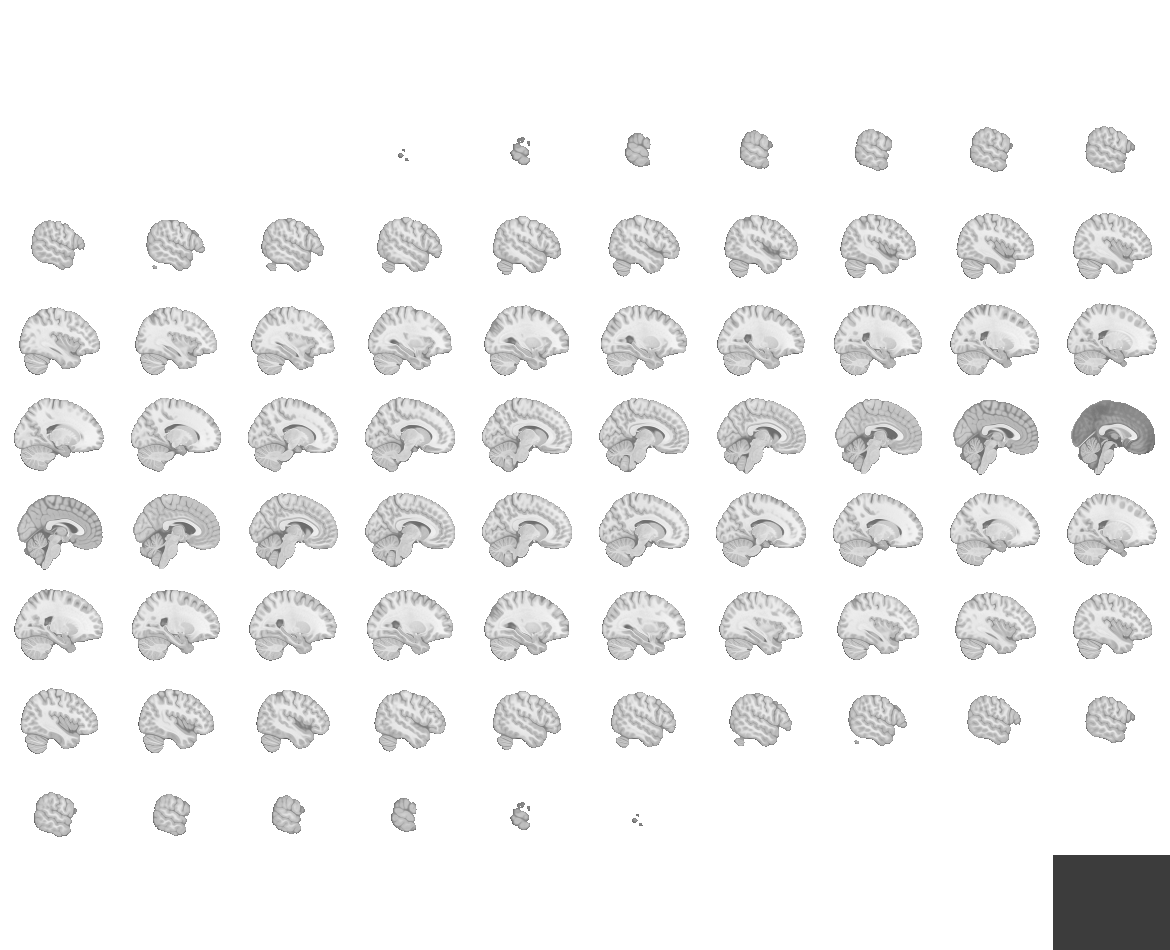
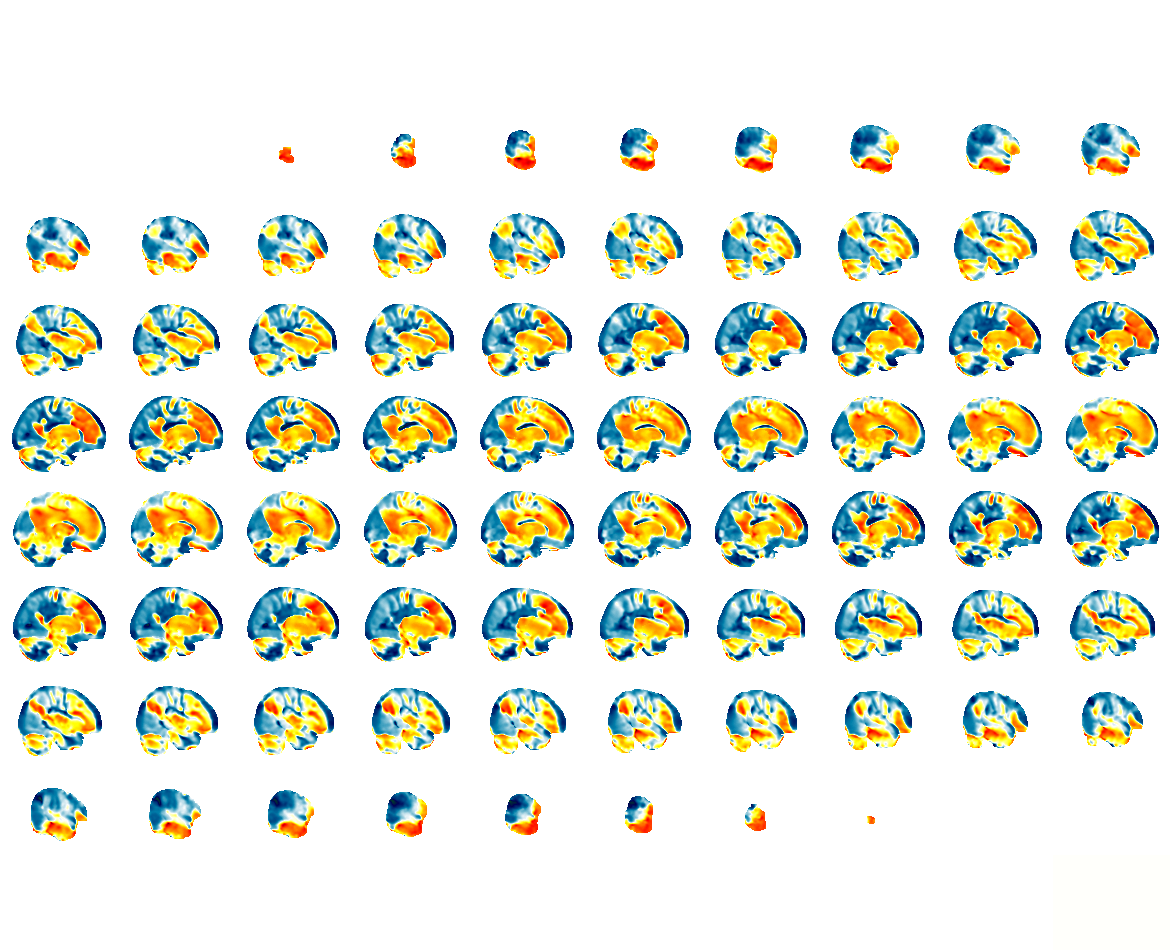

In [18]:
#generate a nifti from the top response specificity map
mask = nimds.get_img("mni_icbm152")
ovr_img1 = image.new_img_like(mask, t_matrix)
ovr_html1 = plotting.view_img(ovr_img1, cut_coords=(0,0,0), title=(f't_matrix'), black_bg=False, opacity=.75, cmap='ocean_hot')
ovr_html1


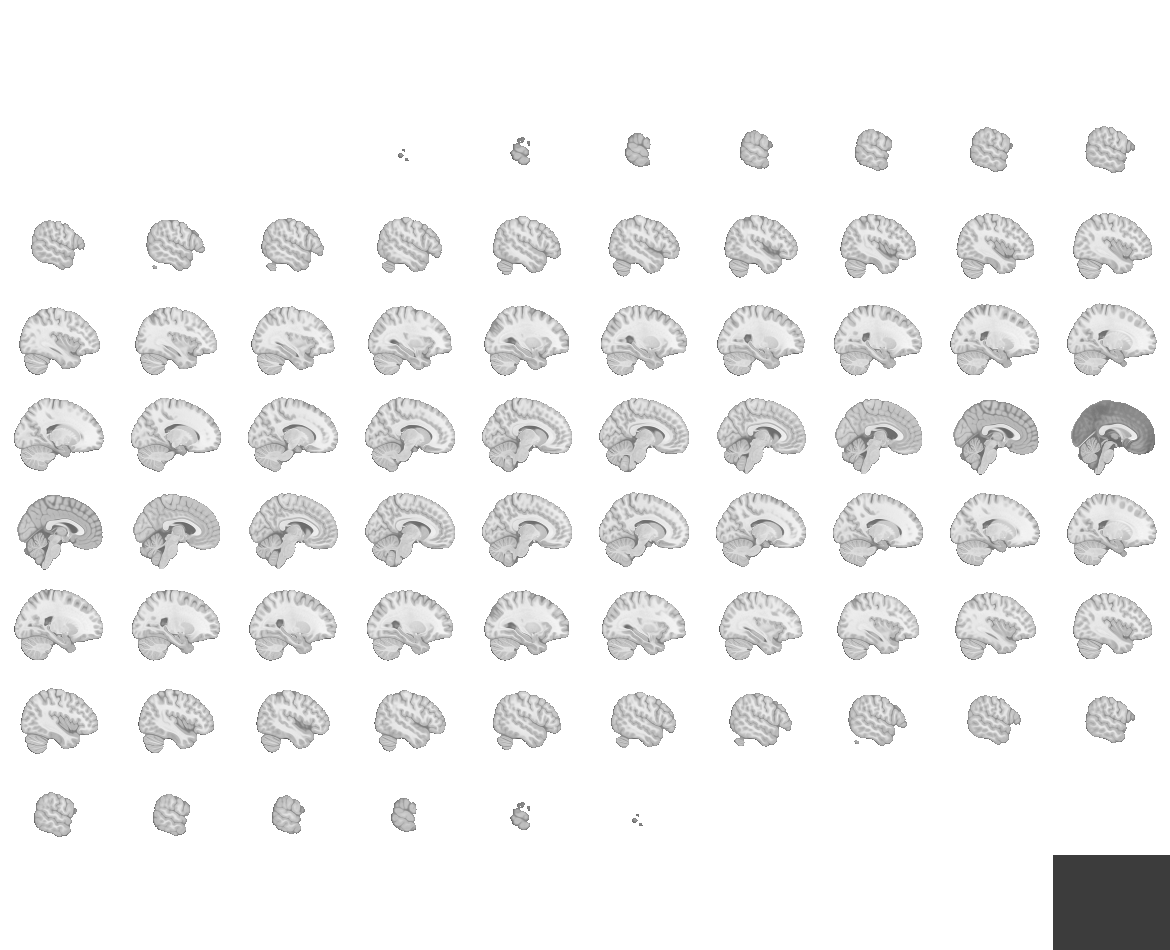
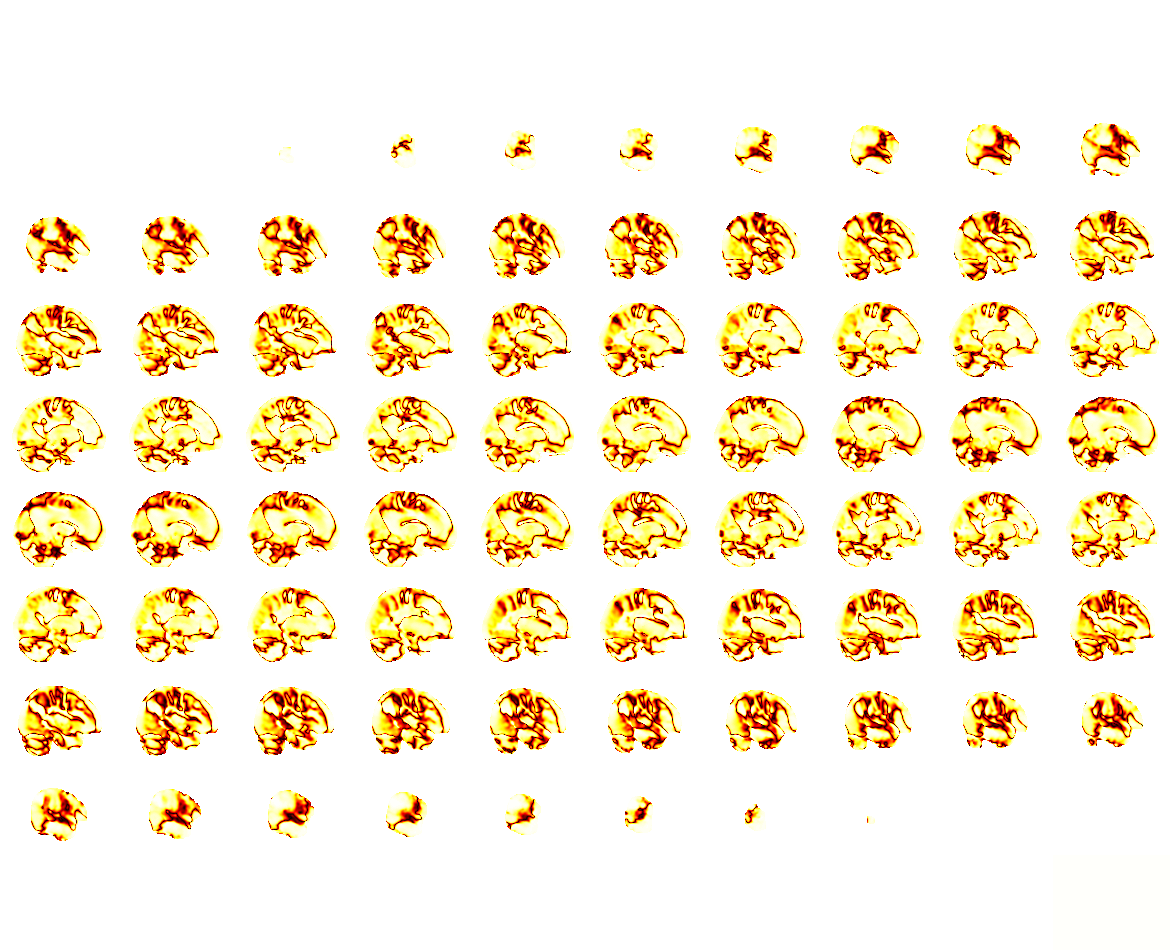

In [19]:
#generate a nifti from the bottom response specificity map
ovr_img2 = image.new_img_like(mask, p_matrix)
ovr_html2 = plotting.view_img(ovr_img2, cut_coords=(0,0,0), title=('p_matrix'), black_bg=False, opacity=.75, cmap='ocean_hot')
ovr_html2


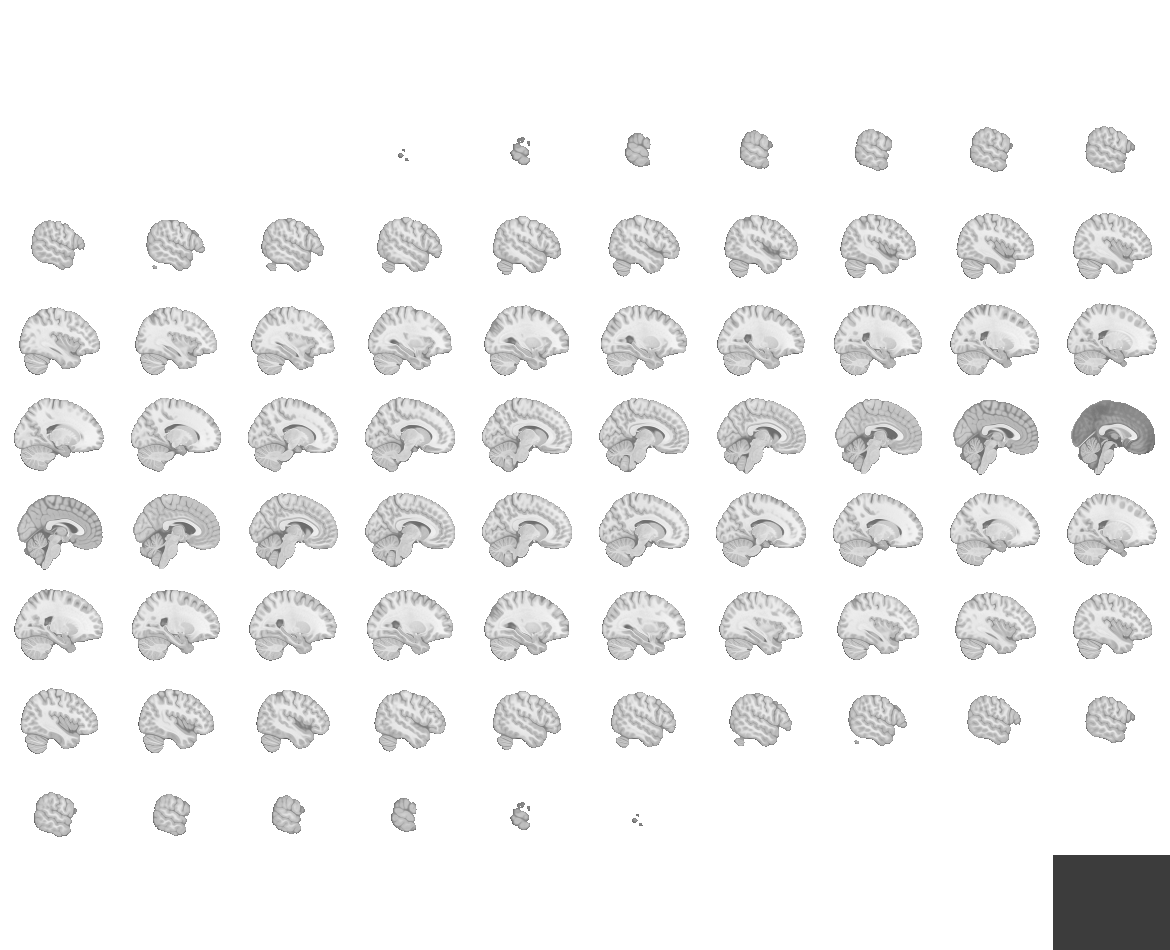
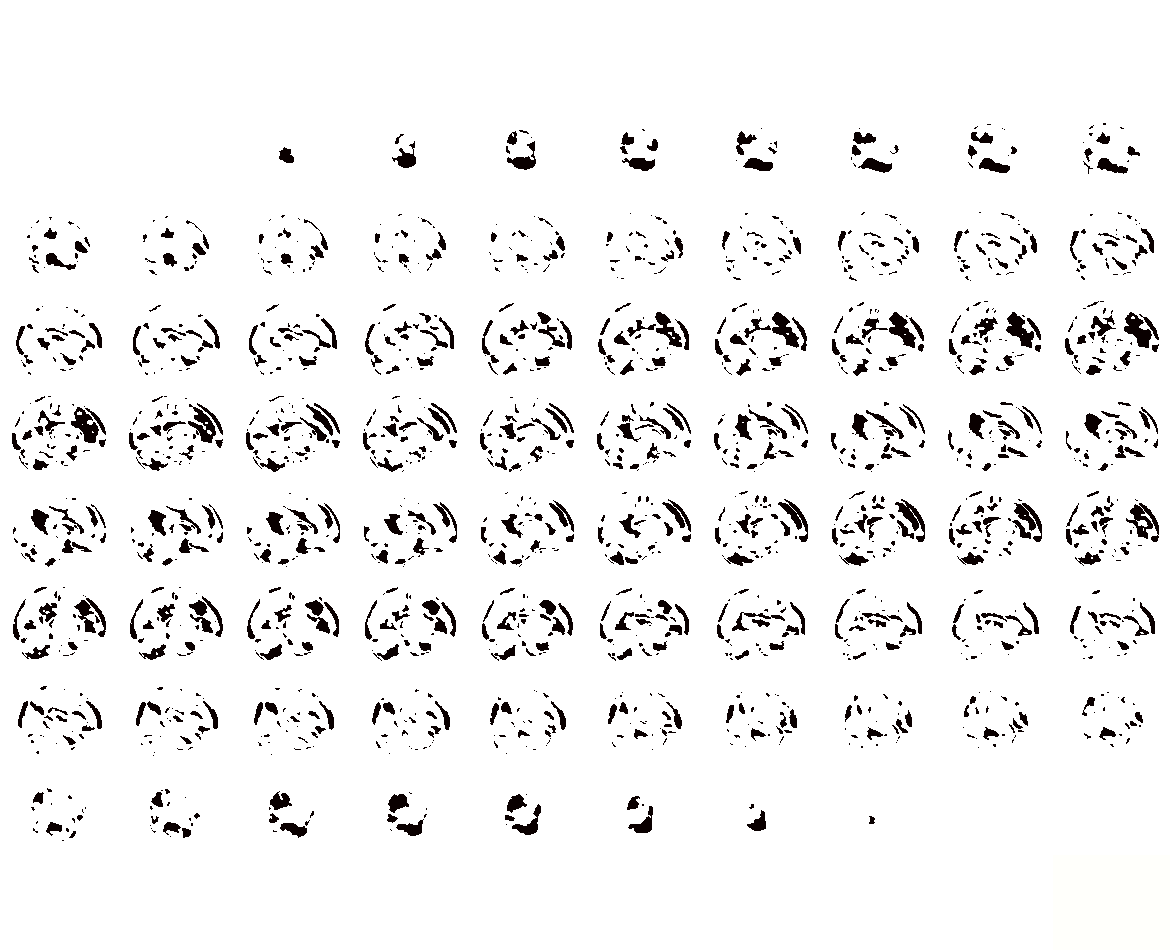

In [20]:
#generate a nifti from the bottom response specificity map
ovr_img3 = image.new_img_like(mask, thresh_p_matrix)
ovr_html3 = plotting.view_img(ovr_img3, cut_coords=(0,0,0), title=('p_matrix<0.05'), black_bg=False, opacity=.75, cmap='ocean_hot')
ovr_html3


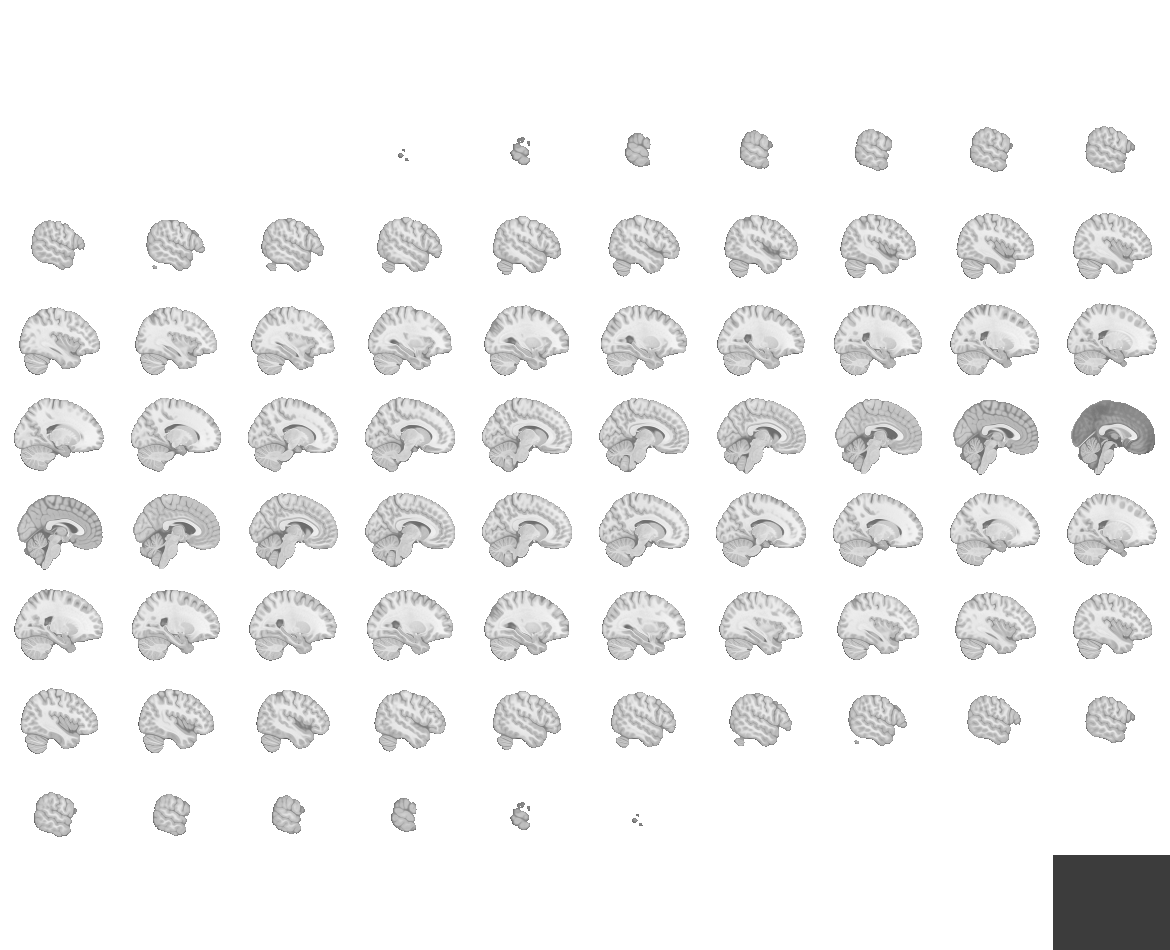
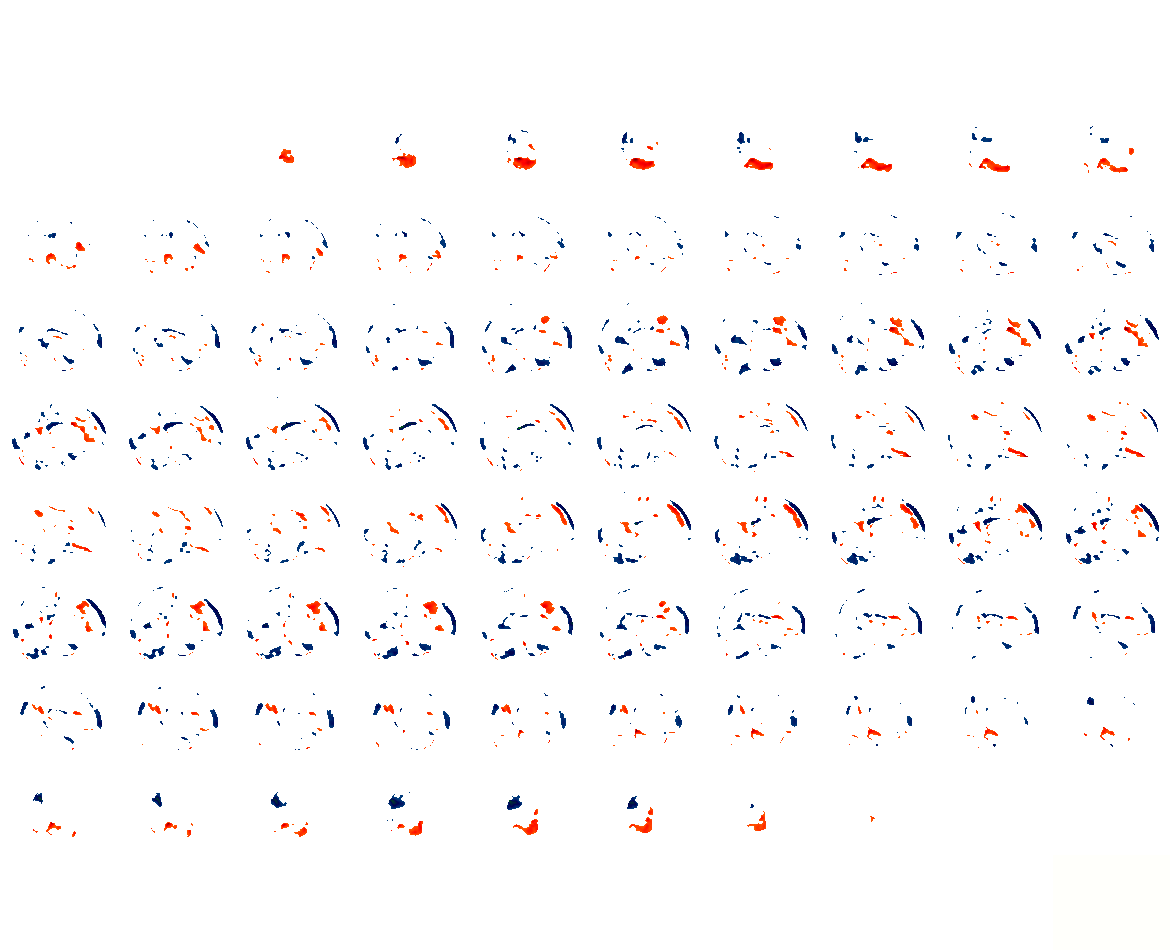

In [21]:
#generate a nifti from the bottom response specificity map
ovr_img4 = image.new_img_like(mask, t_matrix_masked_to_fdr_threshold)
ovr_html4 = plotting.view_img(ovr_img4, cut_coords=(0,0,0), title=('fdr_matrix<0.05'), black_bg=False, opacity=.75, cmap='ocean_hot')
ovr_html4

In [22]:
#Save
if os.path.isdir(out_dir)==False:
    os.mkdir(out_dir)

#Save
ovr_img1.to_filename(os.path.join(out_dir, f'{analysis}_untresholded_t_matrix.nii'))
ovr_html1.save_as_html(os.path.join(out_dir, f'{analysis}_untrehsholded_t_matrix.html'))
ovr_img2.to_filename(os.path.join(out_dir, f'{analysis}_p_matrix.nii'))
ovr_html2.save_as_html(os.path.join(out_dir, f'{analysis}_p_matrix.html'))
ovr_img3.to_filename(os.path.join(out_dir, f'{analysis}_p_thresh_matrix.nii'))
ovr_html3.save_as_html(os.path.join(out_dir, f'{analysis}_p_thresh_matrix.html'))
ovr_img4.to_filename(os.path.join(out_dir, f'{analysis}_t_matrix_masked_to_fdr_under_05.nii'))
ovr_html4.save_as_html(os.path.join(out_dir, f'{analysis}_t_matrix_masked_to_fdr_under_05.html'))

print('Title: ' + 'specificity maps')
print('saved to: ', out_dir)

Title: specificity maps
saved to:  /Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/rios_2022_networks/rios_worst_versus_top_responders_specificity_map_final
